Some thoughts on the challenges of Interpretable Dimension

## What does ID solve?

Turn a non linear classifier into a linear classifier with interpretable concepts. Successfully done, ID will point out important concepts in the classifier for making the decision. 

## How do we evaluate ID?

The main comparison is with visualization techniques to uncover the meaning of individual neuron. Being able to identify important concepts will help us 1) identify confounders (confounders are not likely directly represented by individual neurons) 2) compress network (remove duplicate links)? 3) transfer learned concept detector to other tasks (evaluate whether concepts can transfer) 

## Assumptions?

1. There is a linear relationship between output and concepts
2. Concepts are represented in the pretrained network

## Issues?

1. How do we know assumption 1 is met? If the unknown concepts have large coefficients
2. How do we know assumption 2 is met? We can measure the concepts' interpretability score

## User Interface?

Give me the model you want to explain: (user input)

Give me a list of concepts (concept directory): (user input)

The following concepts are not recognized by the network: (computer output, based on interpretability score)

Do you want to set up unrecognized concepts as auxiliary task?: (user input)

Do you want to proceed with the recognized concepts?: (user input)

Using the recognized concepts, we have the following explanation: 
(computer output: e.g. out of all recognized concepts, red triangle has the highest weight of 0.5, the unknown concepts (do PCA on them so that data are decorrelated) has the highest weigt of 0.9, thus we don't recommend using our explanation)

## Degenerative issues

Since we are doing change of basis, we must make sure the basis matrix is invertible. There could be multiple points in the current implementation that violate this assumption.

1. in solving for least square regression, the learned vector could be a linear combination of previous directions, in this case, we should just give it an arbitrary direction


The main reason for not orthogonal is that the last dimension usually gives theta very close to 0. So solution is to give an arbitrary dimension and then orthogonize. It is also very important to let theta have unit length at the begining to prevent numerical issues.

# Essay on Interpretability

Interpretability is tricky. It's one of those things that you can recognize, but are hard to define. If we cannot formalize what interpretability is, there's no interpretable algorithm. Thus, the core of the subject lies in arguing its definition.

To claim a model is interpretable, one must link concepts from the the model to concepts that are understandable. For example, the weight of a predictor in a linear model maps naturally to the interpretation of the change in outcome if the covariate is increased by 1 unit. Another example is a decision tree, each spliting on a variable maps to an if clause in programming. The tricky thing about a black box model is that its internal concepts are opaque from those used by us humans, that is the translation from a machine concept to a human concept does not exist. In this work, we focus on the translation of neural network concept.

The traditional method has been to look at what an individual neuron means. There has been some success in this attempt, for example, we've learned that a lot of neurons in CNN correspond to object part detectors. However, for a lot more neurons, we still don't understand what's their purpose, sometimes due to the compression of a lot of concepts, somtimes due to lack of vocabulary to describe their concepts.

The insight of this paper is the realization that the translation process does not have to be a one party effort. The machine should actively search its expressable concept space to match concepts of our own. For example, each neuron is just one direction in the representation space, we would be crazy to expect it to be interpretable as if we should expect half banana and half dog to exist in real life.  Of course, the implicit assumption we made here is that there is a common language spoken by both human and machine, without it, there's nothing we can do.

In [568]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os, math
import matplotlib.image as mpimg
import glob, torch
import matplotlib as mpl
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from skimage import io
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import torch.optim as optim
import copy
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
def to_var(x, *args, **kwargs):
    if type(x) is list or type(x) is tuple:
        x = [Variable(x_, *args, **kwargs) for x_ in x]
    else:
        x = Variable(x, *args, **kwargs)
    return x

## Meet Our Data: Shape x Color

Assume we live in a colorful geometric world. All we know are colors and shapes.

In fact, we only know red and green colors, with square or triangle shape as shown below.

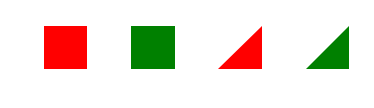

In [3]:
def gen_shape(shape, tx=0, ty=0, c='r', s=0.6, r=0):
    if shape == 'circle':
        shapelet = plt.Circle((tx, ty), radius=s, fc=c)
    elif shape == 'rectangle1':
        shapelet = plt.Rectangle((tx-0.5*s, ty-s), s, 2*s, fc=c)
    elif shape == 'rectangle2':
        shapelet = plt.Rectangle((tx-s, ty-0.5*s), 2*s, s, fc=c)
    elif shape == 'square':
        shapelet = plt.Rectangle((tx-s, ty-s), 2*s, 2*s, fc=c)
    elif shape == 'triangle' or shape == 'triangle1':
        points = [[tx-s, ty-s], [tx+s, ty-s], [tx+s, ty+s]]
        shapelet = plt.Polygon(points, fc=c)
    elif shape == 'triangle2':
        points = [[tx-s, ty-s], [tx+s, ty-s], [tx-s, ty+s]]
        shapelet = plt.Polygon(points, fc=c)
    elif shape == 'triangle3':
        points = [[tx-s, ty-s], [tx+s, ty-s], [tx, ty+s]]
        shapelet = plt.Polygon(points, fc=c)
    elif shape == 'pentagon':
        c1 = 1 / 4 * (math.sqrt(5) - 1)
        c2 = 1 / 4 * (math.sqrt(5) + 1)
        s1 = 1 / 4 * (math.sqrt(10 + 2 * math.sqrt(5)))
        s2 = 1 / 4 * (math.sqrt(10 - 2 * math.sqrt(5)))
        points = [[0,1], [s1, c1], [s2, -c2], [-s2, -c2], [-s1, c1]]
        # scale down and translate these points
        points = list(map(lambda p: [p[0]*s + tx, p[1]*s + ty], points))
        shapelet = plt.Polygon(points, fc=c)

    rotate = mpl.transforms.Affine2D().rotate_deg(r) + plt.gca().transData
    shapelet.set_transform(rotate)
    
    return shapelet

def plot_shape(shapelet, axis='off', name="", xlim=(-1,1), ylim=(-1,1)):
    plt.gca().add_patch(shapelet)
    plt.axis('scaled')
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    if axis is 'off':
        plt.gca().set_axis_off()
    if name is not "":
        basename = 'color_shape_combined/'
        fig_name = basename + "_".join(name.split(" ")) + ".png"
        dirname = os.path.dirname(fig_name)
        if not os.path.exists(dirname):
            os.makedirs(dirname)
        plt.savefig(fig_name)
        plt.close()

plt.subplot('141')
rs = gen_shape('square', c='r')
plot_shape(rs)

plt.subplot('142')
gs = gen_shape('square', c='g')
plot_shape(gs)

plt.subplot('143')
rt = gen_shape('triangle', c='r')
plot_shape(rt)

plt.subplot('144')
gt = gen_shape('triangle', c='g')
plot_shape(gt)
plt.show()

In this world, we only care about triangles and their colors. That is we only have two target classes to distinguish: red triangle (RT) vs. green triangle (GT). However, instead of having pictures of triangles alone, squares love to hangout with triangles, so we have training images like these: 

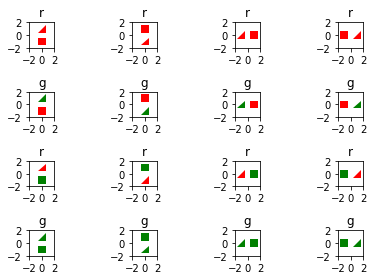

In [744]:
rs = gen_shape('square', c='r')
gs = gen_shape('square', c='g')
rt = gen_shape('triangle', c='r')
gt = gen_shape('triangle', c='g')

def put_shapes(s1, s2, transform1, transform2, axis='off', name=""):
    # assume both s1 and s2 are in range(-1,1)    
    s1.set_transform(transform1)
    s2.set_transform(transform2)
    
    plt.gca().add_patch(s1)
    plt.gca().add_patch(s2)
    plt.axis('scaled')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)    
    if axis == 'off':
        plt.axis('off')
    
    if name is not "":
        basename = 'color_shape_combined/'
        if not os.path.exists(basename):
            os.makedirs(basename)
        plt.savefig(basename + "_".join(name.split(" ")) + ".png", bbox_inches='tight')
        plt.close()

def put_up_down(s1, s2, axis='off', name=""):
    up = mpl.transforms.Affine2D().translate(0, 1)  + plt.gca().transData
    down = mpl.transforms.Affine2D().translate(0, -1)  + plt.gca().transData
    put_shapes(s1, s2, up, down, axis, name)

def put_left_right(s1, s2, axis='off', name=""):
    left = mpl.transforms.Affine2D().translate(-1, 0)  + plt.gca().transData
    right = mpl.transforms.Affine2D().translate(1, 0)  + plt.gca().transData
    put_shapes(s1, s2, left, right, axis, name)

axis = 'on'
for i, (scolor, tcolor, order) in enumerate(itertools.product(['r','g'], ['r','g'], 
                                                              ['u','d','l','r'])):
    plt.subplot(4,4,i+1)
    plt.title(tcolor)
    if order is 'u':
        put_up_down(gen_shape('triangle', c=tcolor), 
                    gen_shape('square', c=scolor), axis)
    elif order is 'd':
        put_up_down(gen_shape('square', c=scolor), 
                    gen_shape('triangle', c=tcolor), axis)
    elif order is 'l':
        put_left_right(gen_shape('triangle', c=tcolor), 
                       gen_shape('square', c=scolor), axis)
    elif order is 'r':
        put_left_right(gen_shape('square', c=scolor), 
                       gen_shape('triangle', c=tcolor), axis)
    
plt.tight_layout()
plt.show()



of course there's ton of small noises in the dataset

### generate dataset

In [184]:
shapes = ['square', 'triangle1']
colors = ['r', 'g']
rotations = [-10, 10]
trans_x = [-0.3, 0.3]
trans_y = trans_x
scales = [0.3, 0.6]
total_count = len(colors) * len(rotations) * len(trans_x) * len(trans_y) * len(scales)
print('single shape datasize: %d' % total_count)

single shape datasize: 32


In [187]:
dirname = 'original_size/'
for i, (stx, ttx, sty, tty, scolor,\
        tcolor, ss, ts, sr, tr, order) in enumerate(itertools.product(trans_x, trans_x,                                                                                                 trans_y, trans_y,
                                                                      colors, colors,
                                                                      scales, scales,
                                                                      rotations, rotations,
                                                                      ['u','d','l','r'])):
    
    if i % 1000 == 0:
        print('progress', i)
    y = tcolor
    tname = "triangle r: %d c: %s tr: (%.1f %.1f) s: %.1f" % (tr, tcolor, ttx, tty, ts) 
    sname = "square r: %d c: %s tr: (%.1f %.1f) s: %.1f" % (sr, scolor, stx, sty, ss) 

    if order is 'u':
        put_up_down(gen_shape('triangle', ttx, tty, tcolor, ts, tr), 
                    gen_shape('square', stx, sty, scolor, ss, sr), name=dirname + 'u ' + sname + tname)
    elif order is 'd':
        put_up_down(gen_shape('square', stx, sty, scolor, ss, sr), 
                    gen_shape('triangle', ttx, tty, tcolor, ts, tr), name=dirname + 'd ' + sname + tname)
    elif order is 'l':
        put_left_right(gen_shape('triangle', ttx, tty, tcolor, ts, tr), 
                       gen_shape('square', stx, sty, scolor, ss, sr), name=dirname + 'l ' + sname + tname)
    elif order is 'r':
        put_left_right(gen_shape('square', stx, sty, scolor, ss, sr), 
                       gen_shape('triangle', ttx, tty, tcolor, ts, tr), name=dirname + 'r ' + sname + tname)


progress 0
progress 1000
progress 2000
progress 3000
progress 4000


The default resolution is too high, convert it to some lower resolution (47 x 50) with the following bash command

```bash
mkdir -p color_shape_combined/original_size/resized

cd color_shape_combined/original_size

find . -maxdepth 1 -iname "*.png" | xargs -L1 -I{} convert -resize 47x50! "{}" resized/"{}"

cd ../..
```

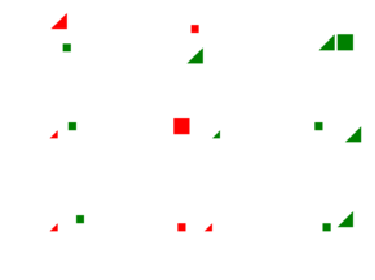

In [191]:
def plot_figures_dir(dirname, top=9):
    side = math.ceil(math.sqrt(top))
    for i, fn in enumerate(glob.glob(dirname)[:top]):
        img=mpimg.imread(fn)
        plt.subplot(side, side, i+1)
        imgplot = plt.imshow(img)
        plt.axis('off')

plot_figures_dir("color_shape_combined/original_size/resized/*")
plt.tight_layout()
plt.show()

### generate explanation dataset: slight variations from the original dataset

In [178]:
concepts = ['red_square', 'red_triangle', 'green_square', 'green_triangle']
n_examples = 100
dirname = 'concepts/'
for c in concepts:
    print('generating %s with %d' % (c, n_examples))
    color, shape = c.split('_')
    
    for i in range(n_examples):
        shapelet = gen_shape(shape, 
                             tx=np.random.uniform(-1.5,1.5), 
                             ty=np.random.uniform(-1.5,1.5), c=color, 
                             s=np.random.choice([0.6,0.3]), 
                             r=np.random.uniform(-10,10))
        plot_shape(shapelet, xlim=(-2,2), ylim=(-2,2), name=dirname + c+'/%d' % i)    

generating red_square with 100
generating red_triangle with 100
generating green_square with 100
generating green_triangle with 100


again we need to resize

```bash
cd color_shape_combined

for fn in concepts/*
do 
   cd $fn
   mkdir -p resized
   find . -maxdepth 1 -iname "*.png" | xargs -L1 -I{} convert -resize 47x50! "{}" resized/"{}"
   cd -
done

cd ../..
```

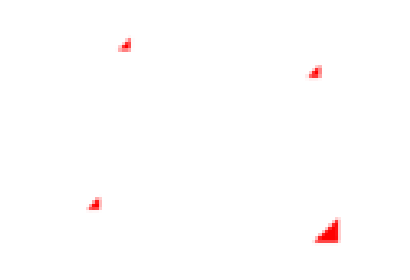

In [188]:
plot_figures_dir("color_shape_combined/concepts/red_triangle/resized/*", 4)
plt.tight_layout()
plt.show()

load into dataloader
## running model starts here

In [4]:
def red_triangle(image_name):
    return image_name.split('/')[-1].split('_')[14] == 'r'

def green_triangle(image_name):
    return image_name.split('/')[-1].split('_')[14] == 'g'

def red_square(image_name):
    return image_name.split('/')[-1].split('_')[5] == 'r'

def green_square(image_name):
    return image_name.split('/')[-1].split('_')[5] == 'g'


class ColorShapeDataset(Dataset):
    
    def __init__(self, root_dir, pos_criteria=red_triangle,transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            pos_criteria: criteria for being considered to be positive, input is image name
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_names = glob.glob(root_dir + '/*.png')
        self.pos_criteria = pos_criteria

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image = io.imread(image_name)
        
        y = self.pos_criteria(image_name)

        if self.transform:
            image = self.transform(image)

        return image, y

define train set and test set

In [16]:
train_portion = 0.8

color_shape_data = ColorShapeDataset('color_shape_combined/original_size/resized/', 
                                     red_triangle,
                                     transforms.Compose([transforms.ToTensor()]))
dataset_size = len(color_shape_data)
splitpoint = math.floor(train_portion*dataset_size)

iter_order = np.random.permutation(dataset_size)
train_subset = iter_order[:splitpoint]
test_subset = iter_order[splitpoint:]

labels 
 0
 0
 1
 1
[torch.LongTensor of size 4]



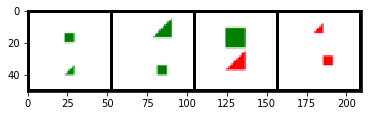

In [17]:
# Helper function to show a batch
def show_tensor_batch(sample_batched):
    """Show image for a batch of samples."""
    images_batch, y = sample_batched
    batch_size = len(images_batch)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
color_shape_dataloader = DataLoader(color_shape_data, batch_size=4, 
                                    sampler=SubsetRandomSampler(train_subset),
                                    num_workers=1)

for x, y in color_shape_dataloader:
    show_tensor_batch((x,y))
    print('labels', y)
    plt.show()
    break

## Meet Our Model: CNN, the last layer has only 4 neurons

In [18]:
class Net(nn.Module):
    def __init__(self, num_class):
        super(Net, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(3,6,5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(6,10,5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(10 * 8 * 9, 4),
            nn.ReLU(inplace=True),
            nn.Linear(4, num_class),            
        )

    def forward(self, x):
        out = self.feature(x).view(x.size(0), 10*8*9)
        return self.classifier(out)

net = Net(2)

trainloader = DataLoader(color_shape_data, batch_size=32, 
                         sampler=SubsetRandomSampler(train_subset),
                         num_workers=1)
testloader = DataLoader(color_shape_data, batch_size=32, 
                        sampler=SubsetRandomSampler(test_subset),
                        num_workers=1)


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

def train(net, trainloader, criterion, optimizer, print_every=10, epochs=2):

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(Variable(inputs))
            loss = criterion(outputs, to_var(labels))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data[0]
            if i % print_every == (print_every-1): 
                print('[%d, %5d] loss: %.10f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    

In [68]:
train(net, trainloader, criterion, optimizer)

[1,    10] loss: 0.0006437423
[1,    20] loss: 0.0005238393
[1,    30] loss: 0.0006311071
[1,    40] loss: 0.0004860946
[1,    50] loss: 0.0004074358
[1,    60] loss: 0.0004364895
[1,    70] loss: 0.0005219233
[1,    80] loss: 0.0003082604
[1,    90] loss: 0.0003331145
[1,   100] loss: 0.0003279001
[2,    10] loss: 0.0002677899
[2,    20] loss: 0.0002518771
[2,    30] loss: 0.0002399656
[2,    40] loss: 0.0002165895
[2,    50] loss: 0.0002479352
[2,    60] loss: 0.0002684831
[2,    70] loss: 0.0002570736
[2,    80] loss: 0.0001961296
[2,    90] loss: 0.0001390852
[2,   100] loss: 0.0001489098
Finished Training


test:


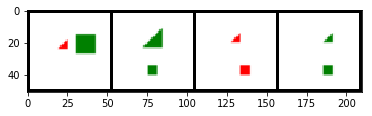

ground truth 
 1
 0
 1
 0
[torch.LongTensor of size 4]

predicted 
 1
 0
 1
 0
[torch.LongTensor of size 4]



In [23]:
def show_dataloader(loader, net=None, top=4):
    dataiter = iter(loader)
    image, y = dataiter.next()
    show_tensor_batch((image[:top], y[:top]))
    plt.show()
    print('ground truth', y[:top])
    if net is not None:
        output = net(Variable(image))
        _, predicted = torch.max(output.data, 1)
        print('predicted', predicted[:top])

print('test:')
show_dataloader(testloader, net=net)
#print('train:')
#show_dataloader(trainloader, net=net)

In [69]:
def show_acc(net, loader, name=""):
    correct = 0
    total = 0

    for data in loader:
        images, labels = data
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += to_var(labels).size(0)
        correct += (predicted == labels).sum()

    print('Accuracy of the network on %d %s images: %d %%' % (len(loader.sampler), name, 100 * correct / total))

show_acc(net, testloader, 'test')
show_acc(net, trainloader, 'train')

Accuracy of the network on 820 test images: 100 %
Accuracy of the network on 3276 train images: 100 %


## Explain the Model: W

Find the explanation photo that best matches neurons in the model

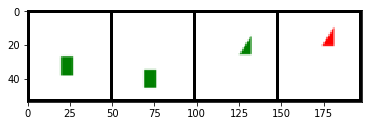

ground truth ('color_shape_combined/concepts/green_square/resized/47.png', 'color_shape_combined/concepts/green_square/resized/62.png', 'color_shape_combined/concepts/green_triangle/resized/24.png', 'color_shape_combined/concepts/red_triangle/resized/65.png')


In [70]:
class ConceptDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        """
        Assumes the root_dir contains directories with the name of the concept
        
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        concept_names = glob.glob(root_dir + '/*')
        self.image_names = []
        self.labels = []
        for concept_dir in concept_names:
            image_names = glob.glob(concept_dir + '/resized/*.png')
            self.image_names.extend(image_names)
            concept_name = concept_dir.split('/')[-1]
            self.labels.extend([concept_name] * len(image_names))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image = io.imread(image_name)
        
        y = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        return image, image_name
    
concept_data = ConceptDataset('color_shape_combined/concepts/', 
                              transform=transforms.Compose([transforms.ToTensor()]))
concept_loader = DataLoader(concept_data, batch_size=32, num_workers=4, 
                            sampler=RandomSampler(concept_data))

show_dataloader(concept_loader)

In [679]:
def explain(net, concept_loader):
    '''explaination in the form of y = sigma(W P P^-1 phi(x))'''
    model = copy.deepcopy(net)
    model.classifier = nn.Sequential(*list(net.classifier.children())[:-1])
    W = list(net.classifier.children())[-1].weight.cpu().data.numpy()
    
    activation_matrix = []
    labels = []
    for x, y in concept_loader:
        activation_matrix.append(model(Variable(x)).data.cpu().numpy())
        labels.extend(y)
    activation_matrix = np.vstack(activation_matrix)
    return activation_matrix, labels, W

def print_result(W, concepts, errors, threshold=0.1, mask=True):
    '''assumes binary classification'''
    coe = W[1] - W[0]
    print('"*" postfixed means error < %.4f' % threshold)
    print('%15s %10s %10s' % ('concepts', 'coeff', 'error'))
    print('-'*37)
    for w, c, e in sorted(zip(coe, concepts, errors), key=lambda x: abs(x[0]), reverse=True):
        if e < threshold:
            c = c+"*"
        else:
            if mask: c = 'unknown'
        print("%15s %10.4f %10.4f" % (c, w, e))   

def eval_direction(theta, c, l, A, plot=False, verbose=False):
    '''concept c, labels l, activation map A'''
    cat = list(map(lambda x: x.split('/')[2], l))
    y = np.zeros(len(cat))
    y[np.array(cat) == c] = 1
    
    n, d = A.shape
    a = A.dot(theta).ravel()
    X = np.vstack([a, np.ones(n)]).T
    m, b = np.linalg.lstsq(X, y)[0]
    error = np.mean((X.dot(np.array([m,b])) - y)**2)
    
    if verbose:
        print('%s error: %.4f, slope: %+.4f, intercept: %+4f' % (c.ljust(14), error, m, b))        
    if plot:
        colors = list(map(switch_color, l))
        transformed = X.dot(np.array([m,b]))
        plt.scatter(transformed, transformed + np.random.random(n), c=colors)
        plt.show()
    return error, m, b

def interpret_direction(t, concepts_list, labels, A):
    min_e = 1000
    min_c = ""
    min_m = 0
    for c in concepts_list:
        e, m, b = eval_direction(t, c, labels, A)
        if e < min_e:
            min_e = e
            min_c = c
            min_m = m
    return min_e, min_m, min_c 
    
activations, labels, W = explain(net, concept_loader)

color_shape_combined/concepts/red_square/resized/84.png
color_shape_combined/concepts/red_triangle/resized/8.png
color_shape_combined/concepts/red_triangle/resized/78.png
color_shape_combined/concepts/red_triangle/resized/61.png


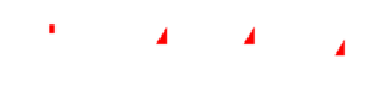

coefficeints [-0.57273757  0.32391644  0.42642879 -0.28805149]

nueron 0
  red_triangle error: 0.1160 sign(slope): -1

nueron 1
  red_triangle error: 0.1017 sign(slope): 1

nueron 2
  red_triangle error: 0.1026 sign(slope): 1

nueron 3
    red_square error: 0.1875 sign(slope): 0
"*" postfixed means error < 0.1300
       concepts      coeff      error
-------------------------------------
  red_triangle*     0.5727     0.1160
  red_triangle*     0.4264     0.1026
  red_triangle*     0.3239     0.1017
        unknown    -0.2881     0.1875
0.126943779619


In [683]:
for i, idx in enumerate(np.argmax(activations, axis=0)):
    fn = labels[idx]
    print(fn)
    img = mpimg.imread(fn)
    plt.subplot(1, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

print('coefficeints', W[1] - W[0])

# explain
plot=False
verbose=True
min_c = []
errors = []
theta_list = []
for i in range(4):
    direction = np.zeros(4)
    direction[i] = 1
    e, m, c = interpret_direction(direction, concepts_order, labels, activations) 
    if m < 0:
        direction = -direction
    theta_list.append(direction)
    min_c.append(c)
    errors.append(e)
    print('\nnueron %d' % i)
    print('%14s error: %.4f sign(slope): %d' % (c, e, np.sign(m)))
    
P = np.vstack(theta_list).T
print_result(W.dot(P), min_c, errors, threshold, mask=True)
print(np.mean(errors))



It seems like the explanation is making sense. Since we are detecting red triangles, we want to discourage green triangle (dimension 3 and 4). However, the high weight on the first 2 dimensions seems troublesome. Detection of green squares seems to hurt the prediction.

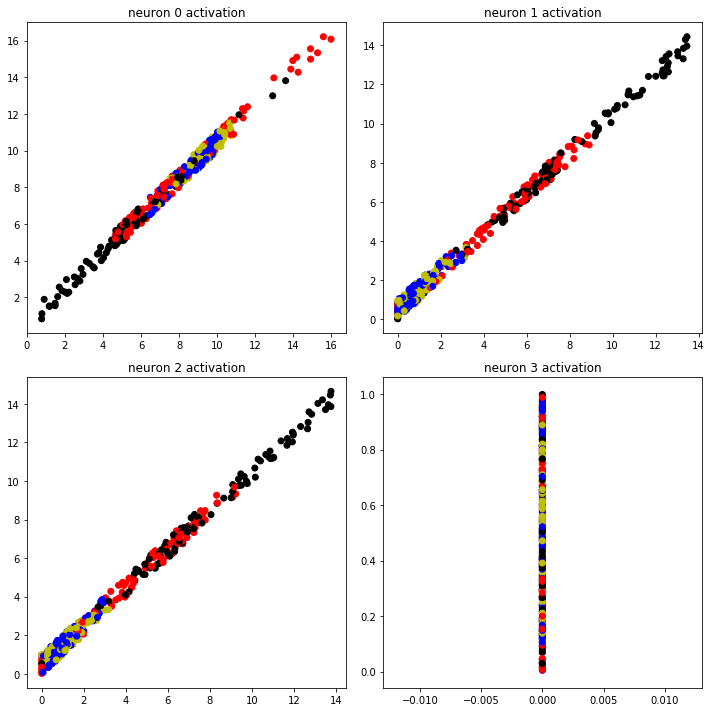

In [681]:
def switch_color(image_name):
    cat = image_name.split('/')[2]
    return {'green_square': 'b', 'green_triangle': 'y', 'red_square': 'r', 'red_triangle': 'k'}[cat]

colors = list(map(switch_color, labels))

plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.scatter(activations[:, i], activations[:, i] + np.random.random(len(activations[:,i])), c=colors)
    plt.title('neuron %d activation' % i)

plt.tight_layout()
plt.show()

## Improve the Explanation: WP

### build theta by least square

The last plot seems like a good way of quantifying what each neuron is detecting. We essentially want one color dots to concentrate on the high end, and all other color dots to concentrate on the low end. We can quantify this relationship pretty easily by normalize activation to range [0, 1] by solving the following optimization function, given the intend interpertation concept c.

$\min_{\theta, b} || X\theta + b -y ||_2$ where $y_i=1$ if $concept(x_i) = c$ else $y_i=0$, and $x_i$ are concepts examples from the concept dataset.

To see whether this is a plausible proxy for measuring interpretability of the dimension, let's first confirm our analysis on the previous two plots.

In [682]:
plot=False
verbose=True
for i in range(4):
    print('\nnueron %d' % i)
    direction = np.zeros(4)
    direction[i] = 1
    eval_direction(direction, 'red_triangle', labels, activations, plot=plot, verbose=verbose)
    eval_direction(direction, 'green_triangle', labels, activations, plot=plot, verbose=verbose)
    eval_direction(direction, 'red_square', labels, activations, plot=plot, verbose=verbose)
    eval_direction(direction, 'green_square', labels, activations, plot=plot, verbose=verbose)    



nueron 0
red_triangle   error: 0.1160, slope: -0.1050, intercept: +1.086889
green_triangle error: 0.1715, slope: +0.0497, intercept: -0.145948
red_square     error: 0.1860, slope: +0.0151, intercept: +0.130006
green_square   error: 0.1770, slope: +0.0403, intercept: -0.070948

nueron 1
red_triangle   error: 0.1017, slope: +0.0805, intercept: -0.051105
green_triangle error: 0.1537, slope: -0.0506, intercept: +0.439140
red_square     error: 0.1805, slope: +0.0231, intercept: +0.163737
green_square   error: 0.1503, slope: -0.0530, intercept: +0.448229

nueron 2
red_triangle   error: 0.1026, slope: +0.0828, intercept: -0.057566
green_triangle error: 0.1542, slope: -0.0518, intercept: +0.442545
red_square     error: 0.1810, slope: +0.0229, intercept: +0.165120
green_square   error: 0.1516, slope: -0.0538, intercept: +0.449902

nueron 3
red_triangle   error: 0.1875, slope: +0.0000, intercept: +0.250000
green_triangle error: 0.1875, slope: +0.0000, intercept: +0.250000
red_square     error: 

However, with this, we really don't know how or if any of the other concepts contribute to our decision making process.

In [273]:
concepts_order = np.array(['red_triangle', 'green_triangle', 'red_square', 'green_square'])

def fit_leastsq_concept(c, l, A, plot=False, verbose=False):
    '''concept c, labels l, activation map A'''
    cat = list(map(lambda x: x.split('/')[2], l))
    y = np.zeros(len(cat))
    y[np.array(cat) == c] = 1
    
    n, d = A.shape
    A = np.hstack([A, np.ones([n, 1])])
    theta = np.linalg.lstsq(A, y)[0]
    error = np.mean((A.dot(theta) - y)**2)
    
    if verbose:
        print('%s error: %.4f' % (c.ljust(14), error))
    if plot:
        colors = list(map(switch_color, l))
        transformed = A.dot(theta).ravel()
        plt.scatter(transformed, transformed + np.random.random(n), c=colors)
        plt.show()
    return theta[:-1], error

plot, verbose = False, True
print('without orthogonal (concept order independent)')
for c in concepts_order:
    theta, error =  fit_leastsq_concept(c, labels, activations, plot, verbose)

without orthogonal (concept order independent)
red_triangle   error: 0.1012
green_triangle error: 0.1480
red_square     error: 0.1239
green_square   error: 0.1302


So this illustrate a limitation of interpretable dimension, that is if too few interpretable concepts are captured in a model, there's nothing we can do (no magic here).

Let's look at how we can build P and look at that interpretation. The way we do that is to iteratively solve for theta and project the data back to an orthogonal plane so that solved theta don't collide with one another.

In [493]:
def check_ortho(theta_list, plot=False, verbose=False):
    Q = [t/np.linalg.norm(t) for t in theta_list]
    Q = np.vstack(Q).T
    error = np.sum(np.abs(Q.T.dot(Q) - np.eye(Q.shape[1])))
    if verbose:
        print("orthogonal check error: ", error)
    if plot:
        print(Q.T.dot(Q))
        plt.matshow(Q.T.dot(Q))
        plt.show()
    return error
    
def orthogonize_(theta, prev_theta_list):
    '''goal: theta should be orthogonal to all vectors in prev_theta_list'''
    theta = theta / np.linalg.norm(theta)
    for t in prev_theta_list:
        theta = theta - theta.dot(t) / np.dot(t,t) * t 
    return theta

def orthogonize(theta, prev_theta_list, verbose=False):
    done = len(prev_theta_list) == 0
    while not done:
        theta = orthogonize_(theta, prev_theta_list)
        #check_ortho(prev_theta_list, plot=False)        
        #check_ortho(prev_theta_list + [theta], plot=False)
        #print('in middle', theta)
        if check_ortho(prev_theta_list + [theta]) > 1e-5:
        #if np.linalg.norm(theta) < 1e-10: # give a random direction to theta to theta too close to 0
            if verbose:
                print('restart a vector')
            theta = np.random.randn(len(theta))
        else:
            done = True
        
    return theta / np.linalg.norm(theta) # to keep theta in a good range for numerical stability

A = copy.deepcopy(activations)
errors = []
theta_list = []

order = [0,1,2,3]
for c in concepts_order[order]:
    theta, error = fit_leastsq_concept(c, labels, A, plot=False)
    
    theta = orthogonize(theta, theta_list) # just make sure theta are orthogonal
    theta_list.append(theta)
    
    A = A - np.outer(A.dot(theta).ravel(), theta) / np.dot(theta, theta) # project data down 1 dimension

errors = list(map(lambda x: x[0], 
                  [eval_direction(t,c,labels,activations) \
                   for c, t in zip(concepts_order[order], theta_list)]))
print('orthogonized (order dependent)')
for c, e in zip(concepts_order[order], errors):
    print('%s error: %.4f' % (c.ljust(14), e))    

orthogonized (order dependent)
red_triangle   error: 0.1012
green_triangle error: 0.1484
red_square     error: 0.1861
green_square   error: 0.1875


In [495]:
threshold = 0.13
P = np.vstack(theta_list).T
newW = W.dot(P)

print('coefficient and concepts without normalization')
print_result(newW, concepts_order[order], errors, threshold, mask=True)

coefficient and concepts without normalization
"*" postfixed means error < 0.1300
       concepts      coeff      error
-------------------------------------
        unknown    -0.7851     0.1861
  red_triangle*     0.2731     0.1012
        unknown    -0.0616     0.1484
        unknown     0.0553     0.1875


let's check are the thetas learned orthogonal.

In [491]:
def ortho_inverse(P):
    out = copy.deepcopy(P.T)
    div = np.diag(P.T.dot(P))
    for i, v in enumerate(div):
        out[i] /= v
    return out
    
check_ortho(theta_list, verbose=True)

orthogonal check error:  8.53334078878e-16


8.5333407887828935e-16

It is very important to normalize activation to have same variance for fair comparison
**note: orthogonalize introduces randomness when direction is restarted, a consequence is the sign in eval_direction could be changed, see note in the following cell**

In [498]:
print('normalizing activation variance')

def buildP(A, concepts_list, labels, plot=False, verbose=False, threshold=0.1875/2):

    def data_range(A, t):
        return A.dot(t/t.dot(t)).ravel().std()

    def normalize_theta(A, t):
        drange = data_range(A, t)
        if drange == 0: # no need to normalize
            return t
        return t * drange # multiply so that in P^-1 is divide by
    
    A_backup = copy.deepcopy(A)
    theta_list = []

    for c in concepts_list:
        theta, error = fit_leastsq_concept(c, labels, A, plot=False, verbose=False)
        theta = orthogonize(theta, theta_list) # just make sure theta are orthogonal # note: randomness here
        theta_list.append(theta)
        A = A - np.outer(A.dot(theta).ravel(), theta) / np.sum(theta**2) # project data down 1 dimension

    # normalize variance
    A = copy.deepcopy(A_backup)
    errors = list(map(lambda x: x[0], 
                      [eval_direction(t, c, labels, A) # note: sign could change here due to restart
                       for c, t in zip(concepts_list, theta_list)]))
    P = np.vstack(theta_list).T
    
    # orthogonize unknown data using pca
    B = A.dot(ortho_inverse(P).T)
    A = []
    ind_changed = []
    for i in range(len(P)):
        if errors[i] >= threshold:
            A.append(B[:,i])
            ind_changed.append(i)
    if len(ind_changed) > 0:
        A = np.vstack(A).T
        pca = PCA(n_components=A.shape[1])
        pca.fit(A)
        
        P_subset = np.vstack([P[:,i] for i in ind_changed]).T

        pca_comp = P_subset.dot(pca.components_.T) # n_comp x d
        for i, ind in enumerate(ind_changed):
            comp = pca_comp[:,i] 
            theta_list[ind] = comp

    # normalize variance
    A = copy.deepcopy(A_backup)
    
    theta_list = [normalize_theta(A, t) for t in theta_list]
    emb = [eval_direction(t, c, labels, A, plot=plot, verbose=verbose)\
           for c, t in zip(concepts_list, theta_list)]    
    errors = list(map(lambda x: x[0], emb))
    slopes = list(map(lambda x: x[1], emb))
    theta_list = list(map(lambda x: x[0] * np.sign(x[1]), zip(theta_list, slopes)))
    
    P = np.vstack(theta_list).T

    return P, errors, theta_list

#np.random.seed(1)
order = [1,0,2,3]
A = copy.deepcopy(activations)
P, errors, theta_list = buildP(A, concepts_order[order], labels, threshold=threshold,verbose=False,plot=False)
newW = W.dot(P)

print_result(newW, concepts_order[order], errors, threshold, mask=True)
check_ortho(theta_list)


normalizing activation variance
"*" postfixed means error < 0.1300
       concepts      coeff      error
-------------------------------------
  red_triangle*     3.1576     0.1026
        unknown    -0.8323     0.1504
        unknown    -0.2525     0.1397
        unknown     0.0216     0.1875


9.6318968379157064e-16

In [500]:
order = [0,1,2,3]
A = copy.deepcopy(activations)
P, errors, theta_list = buildP(A, concepts_order[order], labels, threshold=threshold)
newW = W.dot(P)
print_result(newW, concepts_order[order], errors, threshold, mask=True)
check_ortho(theta_list)


"*" postfixed means error < 0.1300
       concepts      coeff      error
-------------------------------------
        unknown    -3.2708     0.1570
  red_triangle*     0.7465     0.1012
    red_square*    -0.3128     0.1274
        unknown     0.0000     0.1875


1.3568945404944365e-15

In [501]:
order = [3,0,2,1]
A = copy.deepcopy(activations)
P, errors, theta_list = buildP(A, concepts_order[order], labels, threshold=threshold)
newW = W.dot(P)
print_result(newW, concepts_order[order], errors, threshold, mask=True)
check_ortho(theta_list)


"*" postfixed means error < 0.1300
       concepts      coeff      error
-------------------------------------
        unknown    -3.7800     0.1553
    red_square*    -0.3543     0.1279
  red_triangle*     0.2283     0.1020
        unknown     0.0146     0.1875


2.8657240121590433e-15

In [503]:
# debug: the order should monotonically decrease: doesn't necessarily due to orthogonal restart
order = [0,0,0,0]
A = copy.deepcopy(activations)
P, errors, theta_list = buildP(A, concepts_order[order], labels, threshold=threshold, plot=False)
newW = W.dot(P)
print_result(newW, concepts_order[order], errors, threshold, mask=True)
check_ortho(theta_list)


"*" postfixed means error < 0.1300
       concepts      coeff      error
-------------------------------------
  red_triangle*     3.1332     0.1036
  red_triangle*     0.7465     0.1012
  red_triangle*     0.0886     0.1112
  red_triangle*     0.0744     0.1088


4.5721628459011229e-14

This shows the order in which the directions are learned would affect the result, so that we are not sure if red triangle or green triangle is the reason for the classification

In [359]:
Pinv = np.linalg.inv(P)
print('numpy inverse error')
print('P_inv P', np.sum(np.abs(Pinv.dot(P) -np.eye(4))))
print('P P_inv', np.sum(np.abs(P.dot(Pinv) -np.eye(4))))

print('\northogonal inverse error')
print('P_inv P', np.sum(np.abs(ortho_inverse(P).dot(P) -np.eye(4))))
print('P P_inv', np.sum(np.abs(P.dot(ortho_inverse(P)) -np.eye(4))))

numpy inverse error
P_inv P 9.20537163483e-16
P P_inv 5.43764303943e-16

orthogonal inverse error
P_inv P 9.51784683916e-16
P P_inv 9.37414316908e-16


Since we only care about P P_inv case, I'd say P is pretty orthogonal

In [506]:
print('interpret each dimension anyway')

def buildP2(A, concepts_list, labels, plot=False, verbose=False, threshold=0.1875/2):

    def data_range(A, t):
        return A.dot(t/t.dot(t)).ravel().std()

    def normalize_theta(A, t):
        drange = data_range(A, t)
        if drange == 0: # no need to normalize
            return t
        return t * drange # multiply so that in P^-1 is divide by
    
    A_backup = copy.deepcopy(A)
    theta_list = []

    for c in concepts_list:
        theta, error = fit_leastsq_concept(c, labels, A, plot=False, verbose=False)
        theta = orthogonize(theta, theta_list) # just make sure theta are orthogonal # note: randomness here
        theta_list.append(theta)
        A = A - np.outer(A.dot(theta).ravel(), theta) / np.sum(theta**2) # project data down 1 dimension

    # normalize variance
    A = copy.deepcopy(A_backup)
    errors = list(map(lambda x: x[0], 
                      [interpret_direction(t, concepts_list, labels, A) 
                       for t in theta_list]))
    P = np.vstack(theta_list).T
    
    # orthogonize unknown data using pca
    B = A.dot(ortho_inverse(P).T)
    A = []
    ind_changed = []
    for i in range(len(P)):
        if errors[i] >= threshold:
            A.append(B[:,i])
            ind_changed.append(i)
    if len(ind_changed) > 0:
        A = np.vstack(A).T
        pca = PCA(n_components=A.shape[1])
        pca.fit(A)
        
        P_subset = np.vstack([P[:,i] for i in ind_changed]).T

        pca_comp = P_subset.dot(pca.components_.T) # n_comp x d
        for i, ind in enumerate(ind_changed):
            comp = pca_comp[:,i] 
            theta_list[ind] = comp

    # normalize variance
    A = copy.deepcopy(A_backup)
    
    theta_list = [normalize_theta(A, t) for t in theta_list]
    emc = [interpret_direction(t, concepts_list, labels, A)\
           for t in theta_list]    
    errors = list(map(lambda x: x[0], emc))
    slopes = list(map(lambda x: x[1], emc))
    min_c = list(map(lambda x: x[2], emc))
    theta_list = list(map(lambda x: x[0] * np.sign(x[1]), zip(theta_list, slopes)))
    
    P = np.vstack(theta_list).T

    return P, errors, theta_list, min_c

order = [1,0,2,3]
A = copy.deepcopy(activations)
P, errors, theta_list, min_c = buildP2(A, concepts_order[order], labels, 
                                       threshold=threshold,verbose=False,plot=False)
newW = W.dot(P)
print_result(newW, min_c, errors, threshold, mask=True)
check_ortho(theta_list)


interpret each dimension anyway
"*" postfixed means error < 0.1300
       concepts      coeff      error
-------------------------------------
  red_triangle*     3.2421     0.1026
  red_triangle*     0.6429     0.1038
  red_triangle*     0.2279     0.1024
  red_triangle*    -0.0933     0.1183


6.7449435431605291e-16

In [509]:
print('Greedy interpret anyway (order independent)')
def buildP3(A, concepts_list, labels, plot=False, verbose=False, threshold=0.1875/2):

    def data_range(A, t):
        return A.dot(t/t.dot(t)).ravel().std()

    def normalize_theta(A, t):
        drange = data_range(A, t)
        if drange == 0: # no need to normalize
            return t
        return t * drange # multiply so that in P^-1 is divide by
    
    def greedy_find_c(concepts_list, labels, A):
        min_e = 1000
        min_t = 0
        min_c = ""
        for c in concepts_list:
            theta, error = fit_leastsq_concept(c, labels, A, plot=False, verbose=False)
            if error < min_e:
                min_e = error
                min_t = theta
                min_c = c
        return min_c, min_t, min_e
    
    A_backup = copy.deepcopy(A)
    theta_list = []
    
    #concepts_used = []
    for _ in range(len(concepts_list)):
        min_c, theta, error = greedy_find_c(concepts_list, labels, A)
        #concepts_used.append(min_c)
        theta = orthogonize(theta, theta_list) # just make sure theta are orthogonal # note: randomness here
        theta_list.append(theta)
        A = A - np.outer(A.dot(theta).ravel(), theta) / np.sum(theta**2) # project data down 1 dimension

    # normalize variance
    A = copy.deepcopy(A_backup)
    errors = list(map(lambda x: x[0], 
                      [interpret_direction(t, concepts_list, labels, A) 
                       for t in theta_list]))
    P = np.vstack(theta_list).T
    
    # orthogonize unknown data using pca
    B = A.dot(ortho_inverse(P).T)
    A = []
    ind_changed = []
    for i in range(len(P)):
        if errors[i] >= threshold:
            A.append(B[:,i])
            ind_changed.append(i)
    if len(ind_changed) > 0:
        A = np.vstack(A).T
        pca = PCA(n_components=A.shape[1])
        pca.fit(A)
        
        P_subset = np.vstack([P[:,i] for i in ind_changed]).T

        pca_comp = P_subset.dot(pca.components_.T) # n_comp x d
        for i, ind in enumerate(ind_changed):
            comp = pca_comp[:,i] 
            theta_list[ind] = comp

    # normalize variance
    A = copy.deepcopy(A_backup)
    
    theta_list = [normalize_theta(A, t) for t in theta_list]
    emc = [interpret_direction(t, concepts_list, labels, A)\
           for t in theta_list]    
    errors = list(map(lambda x: x[0], emc))
    slopes = list(map(lambda x: x[1], emc))
    min_c = list(map(lambda x: x[2], emc))
    theta_list = list(map(lambda x: x[0] * np.sign(x[1]), zip(theta_list, slopes)))
    
    P = np.vstack(theta_list).T

    return P, errors, theta_list, min_c

A = copy.deepcopy(activations)
P, errors, theta_list, min_c = buildP3(A, concepts_order, labels, 
                                       threshold=threshold,verbose=False,plot=False)
newW = W.dot(P)
print_result(newW, min_c, errors, threshold, mask=True)
check_ortho(theta_list)


Greedy interpret anyway (order independent)
"*" postfixed means error < 0.1300
       concepts      coeff      error
-------------------------------------
  red_triangle*     3.3631     0.1022
  red_triangle*     0.7465     0.1012
    red_square*    -0.2088     0.1248
    red_square*    -0.0561     0.1252


2.5941577322870466e-15

## TODO:

1. Try an approach that interpret a direction even after PCA and also before trying PCA (done, need refactor)
2. get confounder really working: that is change the correlation
3. find out the reason why need to restart using least square regression

From the coefficient, we know that to be a red triangle, it is important to be red (red square and red triangle has positive weights). However, as we know that red square shouldn't have positive weight, it leaves us wondering what is red_square really detecting. Looking at its activation plot, we see that it is actually detecting not green triangle. In this case, because every concepts except for green triangle is modeled robustly, our explanation doesn't helps much.

On the positive side, we learnt that the model doesn't directly model other shape color combination.

To make our method work, either we can add learning the desired concept as an auxillary task, or we try to find other concept in which the network does model. For simplicity, in this case, I'd train an auxilary task.

## Auxiliary task to force learning new concepts

In [650]:
class Net_Aux(nn.Module): # auxilliary task network
    def __init__(self, net, num_aux_class):
        '''
        net is the original network, we use the last layer activation and 
        add a linear layer to predict auxilliary task
        '''
        super(Net_Aux, self).__init__()
        self.aux_net = nn.Linear(4, num_aux_class)
        
        self.model = copy.deepcopy(net)
        self.classifier_net = list(self.model.classifier.children())[-1]
        self.model.classifier = nn.Sequential(*list(self.model.classifier.children())[:-1])

    def forward(self, x):
        out = self.model(x)
        out_c = self.classifier_net(out)
        out_a = self.aux_net(out)
        return out_c, out_a
    
    def forwardNet(self, x):
        out = self.model(x)
        out_c = self.classifier_net(out)
        return out_c
    
    def forwardAux(self, x):
        out = self.model(x)
        out_a = self.aux_net(out)
        return out_a

class ColorShapeAuxDataset(Dataset):
    
    def __init__(self, root_dir, pos_criteria=red_triangle,transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            pos_criteria: criteria for being considered to be positive, input is image name
            transform (callable, optional): Optional transform to be applied
                on a sample.
                
        Outptut:
            different from ColorShapeDataset, the y output now is an array containing answers
            to the main task and the auxillary tasks
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_names = glob.glob(root_dir + '/*.png')
        self.pos_criteria = pos_criteria

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image = io.imread(image_name)
        
        y = []
        y.append(self.pos_criteria(image_name)) # main task
        # aux tasks: ['red_triangle', 'red_square', 'green_triangle', 'green_square']
        y.append(red_triangle(image_name))
        y.append(red_square(image_name))
        y.append(green_triangle(image_name))
        y.append(green_square(image_name))
        
        if self.transform:
            image = self.transform(image)

        return image, y
    


In [651]:
color_shape_aux_data = ColorShapeAuxDataset('color_shape_combined/original_size/resized/', 
                                         red_triangle,
                                         transforms.Compose([transforms.ToTensor()]))
trainloader_aux = DataLoader(color_shape_aux_data, batch_size=32, 
                             sampler=SubsetRandomSampler(train_subset),
                             num_workers=4)
testloader_aux = DataLoader(color_shape_aux_data, batch_size=32, 
                             sampler=SubsetRandomSampler(test_subset),
                             num_workers=4)

#show_dataloader(trainloader_aux, top=5)#, net_aux.forwardNet)

In [652]:
net_aux = Net_Aux(net, 4) # 4 more tasks to predict

def logitLoss(x, y):
    return torch.mean(torch.log(1 + torch.exp(x)) - x * y.float())

def criterion_aux(outputs, y):
    out_c, out_a = outputs
    y0, y1, y2, y3, y4 = y
    # add the new tasks here
    loss = nn.CrossEntropyLoss()(out_c, y0) 
    loss += logitLoss(out_a[:,0], y1)
    loss += logitLoss(out_a[:,1], y2)
    loss += logitLoss(out_a[:,2], y3)
    loss += logitLoss(out_a[:,3], y4)
    return loss

optimizer_aux = optim.Adam(net_aux.parameters())

In [656]:
train(net_aux, trainloader_aux, criterion_aux, optimizer_aux)

[1,    10] loss: 0.0204189824
[1,    20] loss: 0.0160004969
[1,    30] loss: 0.0149709772
[1,    40] loss: 0.0151463417
[1,    50] loss: 0.0138136212
[1,    60] loss: 0.0139996699
[1,    70] loss: 0.0124699014
[1,    80] loss: 0.0123346330
[1,    90] loss: 0.0108815907
[1,   100] loss: 0.0094664729
[2,    10] loss: 0.0084571671
[2,    20] loss: 0.0077115818
[2,    30] loss: 0.0067377484
[2,    40] loss: 0.0060552260
[2,    50] loss: 0.0055324849
[2,    60] loss: 0.0051660048
[2,    70] loss: 0.0044253426
[2,    80] loss: 0.0048477306
[2,    90] loss: 0.0045450293
[2,   100] loss: 0.0042360782
Finished Training


In [657]:
show_acc(net_aux.forwardNet, testloader, 'test')
show_acc(net_aux.forwardNet, trainloader, 'train')

Accuracy of the network on 820 test images: 100 %
Accuracy of the network on 3276 train images: 99 %


In [658]:
def show_acc_sigmoid(net, loader, name=""):
    correct = 0
    total = 0
    first = True
    
    for data in loader:
        images, labels = data
        labels = labels[1:]
        if first:
            correct = np.zeros(len(labels))
            first = False
        outputs = net(Variable(images))
        outputs = (nn.Sigmoid()(outputs) >= 0.5).long()
        total += outputs.size(0)
        for i in range(len(labels)):
            correct[i] += (outputs[:,i] == to_var(labels[i])).sum().data[0]
    return total, correct

# show auxilliary task acc
#net_aux.aux_net.weight
total, correct = show_acc_sigmoid(net_aux.forwardAux, testloader_aux, 'test')

In [659]:
print([c/total for c in correct])
print(['red_triangle', 'red_square', 'green_triangle', 'green_square'])
correct

[1.0, 0.90000000000000002, 0.99024390243902438, 0.83292682926829265]
['red_triangle', 'red_square', 'green_triangle', 'green_square']


array([ 820.,  738.,  812.,  683.])

In [670]:
B = net_aux.aux_net.weight.data.cpu().numpy()

### W explanation for aux data 

In [671]:
def explain_aux(net, concept_loader):
    '''explaination in the form of y = sigma(W P P^-1 phi(x))'''
    model = net.model
    W = net.classifier_net.weight.cpu().data.numpy()
    
    activation_matrix = []
    labels = []
    for x, y in concept_loader:
        activation_matrix.append(model(Variable(x)).data.cpu().numpy())
        labels.extend(y)
    activation_matrix = np.vstack(activation_matrix)
    return activation_matrix, labels, W
    
activations_aux, labels_aux, W_aux = explain_aux(net_aux, concept_loader)

In [678]:
concepts_order = ['red_triangle', 'red_square', 'green_triangle', 'green_square']
for i in range(len(B)):
    e, m, _ = eval_direction(B[i], concepts_order[i], labels_aux, activations_aux) 
    print(e, m, concepts_order[i])

0.0951478724771 0.146272141059 red_triangle
0.0960814524537 0.226949523248 red_square
0.166559963797 0.0556471336229 green_triangle
0.137554515038 0.146264234177 green_square


how meaningful are random directions?


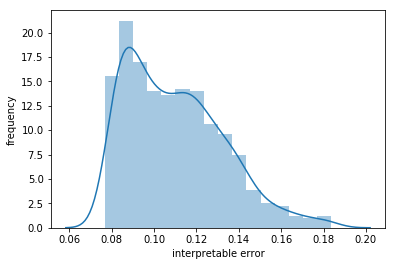

0.10991285634524076

In [581]:
print('how meaningful are random directions?')
nruns = 1000
errors = []
for i in range(nruns):
    e, m, c = interpret_direction(np.random.randn(4), concepts_order, labels_aux, activations_aux) 
    errors.append(e)
sns.distplot(errors)
plt.ylabel('frequency')
plt.xlabel('interpretable error')
plt.show()
np.mean(errors)

color_shape_combined/concepts/red_square/resized/99.png
color_shape_combined/concepts/red_square/resized/2.png
color_shape_combined/concepts/red_triangle/resized/78.png
color_shape_combined/concepts/red_square/resized/84.png


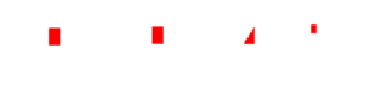

coefficeints [-0.67612153  0.47422418  0.64644027 -0.29483742]

nueron 0
  red_triangle error: 0.1127 sign(slope): -1

nueron 1
  green_square error: 0.1305 sign(slope): -1

nueron 2
  red_triangle error: 0.0964 sign(slope): 1

nueron 3
    red_square error: 0.1315 sign(slope): -1
"*" postfixed means error < 0.1300
       concepts      coeff      error
-------------------------------------
  red_triangle*     0.6761     0.1127
  red_triangle*     0.6464     0.0964
        unknown    -0.4742     0.1305
        unknown     0.2948     0.1315
0.117786392908


In [664]:
for i, idx in enumerate(np.argmax(activations_aux, axis=0)):
    fn = labels_aux[idx]
    print(fn)
    img = mpimg.imread(fn)
    plt.subplot(1, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

print('coefficeints', W_aux[1] - W_aux[0])

# explain
plot=False
verbose=True
min_c = []
errors = []
theta_list = []
for i in range(4):
    direction = np.zeros(4)
    direction[i] = 1
    e, m, c = interpret_direction(direction, concepts_order, labels_aux, activations_aux) 
    if m < 0:
        direction = -direction
    theta_list.append(direction)
    min_c.append(c)
    errors.append(e)
    print('\nnueron %d' % i)
    print('%14s error: %.4f sign(slope): %d' % (c, e, np.sign(m)))
    
P = np.vstack(theta_list).T
print_result(W_aux.dot(P), min_c, errors, threshold, mask=True)
print(np.mean(errors))

In [665]:
print('what does the network understand?')
plot, verbose = False, True
print('without orthogonal (concept order independent)')
errors = []
for c in concepts_order:
    theta, error =  fit_leastsq_concept(c, labels_aux, activations_aux, plot, verbose)
    errors.append(error)
print(np.mean(errors))

what does the network understand?
without orthogonal (concept order independent)
red_triangle   error: 0.0638
green_triangle error: 0.1286
red_square     error: 0.0758
green_square   error: 0.1143
0.0956188995755


In [666]:
print('WP interpret anyway')
order = [0,1,2,3]
A = copy.deepcopy(activations_aux)
P, errors, theta_list, min_c = buildP2(A, concepts_order[order], labels_aux, 
                                       threshold=threshold,verbose=False,plot=False)
newW = W_aux.dot(P)
print_result(newW, min_c, errors, threshold, mask=False)
print(np.mean(errors))

WP interpret anyway
"*" postfixed means error < 0.1300
       concepts      coeff      error
-------------------------------------
  red_triangle*     5.4140     0.1116
    red_square*    -1.4540     0.1175
    red_square*     0.1351     0.1210
  red_triangle*     0.0577     0.0638
0.103470832295


In [667]:
print('WP greedy anyway')
A = copy.deepcopy(activations_aux)
P, errors, theta_list, min_c = buildP3(A, concepts_order, labels_aux, 
                                       threshold=threshold,verbose=False,plot=False)
newW = W_aux.dot(P)
print_result(newW, min_c, errors, threshold, mask=False)
print(np.mean(errors))

WP greedy anyway
"*" postfixed means error < 0.1300
       concepts      coeff      error
-------------------------------------
  red_triangle*     4.1394     0.1208
  red_triangle*     2.5066     0.1256
  red_triangle*     0.0577     0.0638
    red_square*    -0.0066     0.0762
0.0965840771929


Current takeaways:

1. the explanations of W and WP tends to agree
2. the interpretability of WP is slightly higher than W
3. random directionsare quite interpretable

How do we limit W?

we need a model that is fairly complex, but the task should again be easy enough

## Introduce confounder: RT ~ GS

start from GS, RS model, then recreate the dataset and train with the old model

In [426]:
net2 = Net(2)

green_square_data = ColorShapeDataset('color_shape_combined/original_size/resized/', 
                                     green_square,
                                     transforms.Compose([transforms.ToTensor()]))

trainloader2 = DataLoader(green_square_data, batch_size=32, 
                         sampler=SubsetRandomSampler(train_subset),
                         num_workers=4)
testloader2 = DataLoader(green_square_data, batch_size=32, 
                         sampler=SubsetRandomSampler(test_subset),
                         num_workers=4)


In [427]:
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(net2.parameters())

train(net2, trainloader2, criterion2, optimizer2)

[1,    10] loss: 0.0035214192
[1,    20] loss: 0.0033738096
[1,    30] loss: 0.0030995546
[1,    40] loss: 0.0029537059
[1,    50] loss: 0.0026892515
[1,    60] loss: 0.0020129184
[1,    70] loss: 0.0021518419
[1,    80] loss: 0.0018535325
[1,    90] loss: 0.0017955938
[1,   100] loss: 0.0017028076
[2,    10] loss: 0.0015541420
[2,    20] loss: 0.0014598360
[2,    30] loss: 0.0012577055
[2,    40] loss: 0.0012386259
[2,    50] loss: 0.0009892407
[2,    60] loss: 0.0010070287
[2,    70] loss: 0.0011232527
[2,    80] loss: 0.0010112567
[2,    90] loss: 0.0008969869
[2,   100] loss: 0.0008098836
Finished Training


In [456]:
show_acc(net2, trainloader2, 'train')
show_acc(net2, testloader2, 'test')

Accuracy of the network on 3276 train images: 98 %
Accuracy of the network on 820 test images: 97 %


In [457]:
activations2, labels2, W2 = explain(net2, concept_loader)

W explaination


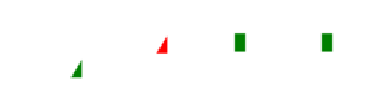

coefficeints [-0.61756492 -0.64131325  0.50590301  1.01482534]

nueron 0
  green_square error: 0.0875 sign(slope): -1

nueron 1
green_triangle error: 0.1875 sign(slope): 0

nueron 2
  green_square error: 0.0762 sign(slope): 1

nueron 3
  green_square error: 0.0755 sign(slope): 1
"*" postfixed means error < 0.1300
       concepts      coeff      error
-------------------------------------
  green_square*     1.0148     0.0755
        unknown    -0.6413     0.1875
  green_square*    -0.6176     0.0875
  green_square*     0.5059     0.0762


In [515]:
print('W explaination')
for i, idx in enumerate(np.argmax(activations2, axis=0)):
    fn = labels2[idx]
    #print(fn)
    img = mpimg.imread(fn)
    plt.subplot(1, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

print('coefficeints', W2[1] - W2[0])

# explain
plot=False
verbose=True
min_c = []
errors = []
for i in range(4):
    direction = np.zeros(4)
    direction[i] = 1
    e, m, c = interpret_direction(direction, concepts_order, labels2, activations2) 
    min_c.append(c)
    errors.append(e)
    print('\nnueron %d' % i)
    print('%14s error: %.4f sign(slope): %d' % (c, e, np.sign(m)))
    
print_result(W2, min_c, errors, threshold, mask=True)

In [520]:
print('what does the network understand?')
plot, verbose = False, True
print('without orthogonal (concept order independent)')
for c in concepts_order:
    theta, error =  fit_leastsq_concept(c, labels2, activations2, plot, verbose)

what does the network understand?
without orthogonal (concept order independent)
red_triangle   error: 0.1603
green_triangle error: 0.1642
red_square     error: 0.1189
green_square   error: 0.0722


In [522]:
print('WP interpret anyway')
order = [1,0,2,3]
A = copy.deepcopy(activations2)
P, errors, theta_list, min_c = buildP2(A, concepts_order[order], labels2, 
                                       threshold=threshold,verbose=False,plot=False)
newW = W2.dot(P)
print_result(newW, min_c, errors, threshold, mask=True)

WP interpret anyway
"*" postfixed means error < 0.1300
       concepts      coeff      error
-------------------------------------
  green_square*     1.7092     0.0769
  green_square*     1.0790     0.0782
        unknown     0.0109     0.1481
        unknown    -0.0000     0.1875


In [518]:
print('WP greedy anyway')
A = copy.deepcopy(activations2)
P, errors, theta_list, min_c = buildP3(A, concepts_order, labels2, 
                                       threshold=threshold,verbose=False,plot=False)
newW = W2.dot(P)
print_result(newW, min_c, errors, threshold, mask=True)

WP greedy anyway
"*" postfixed means error < 0.1300
       concepts      coeff      error
-------------------------------------
  green_square*     1.6017     0.0780
  green_square*     0.8847     0.0808
  green_square*     0.3106     0.0722
        unknown     0.0000     0.1875


so both tells you green square is the confounder. This means this is a too easy task

## A more complicated task: 

The idea is to force the network to learn all 4 concepts